# WHU Experiment

In [9]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

import plotly.graph_objects as go
import numpy as np 
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices

import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from torchvision import transforms
from config import get_sensat_cfg
from model.models import VoxMeshHead

from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

import open3d as o3d

In [2]:
depth_scale = 64
depth_min = 50
depth_max = 450

num_mesh_vertices = 1024
image_size = 512
focal_length = -2

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

save_model_path = "checkpoints/Sem_Dice/model_best_depth.tar"
# device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The

VoxMeshHead(
  (backbone): ResNetBackbone(
    (conv1): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (stem): Sequential(
      (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3,

In [5]:
from loss import MeshHybridLoss

loss_fn = MeshHybridLoss(512, 2, device=device)
loss_fn.set_semantic_weight(0)

In [32]:
depth_scale = 64

initial_losses = []
refined_losses = []

directory = '002_50'

noisy = True
# n_samples = 1000

pcds_file = 'Pcds' if noisy else 'Pcds_1000'

for i in range(10):
    file_number = str(i).zfill(4) 
    
    rgb_file = f"whu_test/{directory}/Images/{file_number}.png"
    sparse_depth_file = f"whu_test/{directory}/{pcds_file}/{file_number}.png"
    gt_depth_file = f"whu_test/{directory}/Depths/{file_number}.png"
    pcd = o3d.io.read_point_cloud(f"whu_test/{directory}/Pcds/{file_number}.ply")
    gt_mesh_pcd = torch.tensor(np.asarray(pcd.points), dtype=torch.float).unsqueeze(0).to(device)
    
    rgb = imread(rgb_file)
    sparsedepth = imread(sparse_depth_file)/depth_scale 
    gt_depth = imread(gt_depth_file)/depth_scale

    padding = 10  # Define the padding size

    # Create a mask for the region of interest (within padding from the edges)
    mask = np.zeros_like(sparsedepth, dtype=bool)
    mask[padding:-padding, padding:-padding] = True

    # Convert sparse depth to boolean based on a threshold (e.g., greater than 0)
    sparsedepth_bool = sparsedepth > 0  # Adjust threshold as needed
    
    # Get nonzero indices within the region of interest
    nonzero_indices = np.nonzero(sparsedepth_bool & mask)
    
    # flat_indices = np.ravel_multi_index(nonzero_indices, sparsedepth.shape)
    
    # # Sample 500 indices
    # sampled_indices = np.random.choice(flat_indices, size=n_samples, replace=False)
    
    # # Convert sampled indices back to original indices
    # nonzero_indices = np.unravel_index(sampled_indices, sparsedepth.shape)
    
    # The input is an RGB image
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(rgb)
    input_img = input_tensor.unsqueeze(0).to(device)
    pred_semantic_features = model_2dseg(input_img)["out"]
    pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
    
    # Initialize the mesh using only the sparse depth
    init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
    init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
    init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
    init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])
    
    init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)

    # Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
    rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
    init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
    sparsedepth_mask = (sparsedepth<=0)*1
    depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
    depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
    input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)
    
    # Normalized the mesh
    init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
    init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
    init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])
    
    # The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
    refine_mesh = model(input_img, init_mesh, pred_semantic_features)

    loss, losses = loss_fn(refine_mesh, None, gt_mesh_pcd, torch.tensor(gt_depth).to(device), None)

    print(losses['chamfer_1'] / 1024)
    
    refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))
    
    refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)

    gathered_gt = gt_depth[nonzero_indices]
    gathered_init = init_mesh_depth[nonzero_indices]
    gathered_refined = refine_mesh_depth[nonzero_indices]

    l2_loss_init = np.mean(np.abs(gathered_gt - gathered_init))
    initial_losses.append(l2_loss_init)
    
    positive_indices = np.where(gathered_refined > 0)
    gathered_gt = gathered_gt[positive_indices]
    gathered_refined = gathered_refined[positive_indices]

    l2_loss_refined = np.mean(np.abs(gathered_gt - gathered_refined))
    refined_losses.append(l2_loss_refined)

    if (i % 10 == 0):
        print(i, l2_loss_init, l2_loss_refined)

    


/tmp/ipykernel_1655129/3073231394.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imread(rgb_file)
/tmp/ipykernel_1655129/3073231394.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sparsedepth = imread(sparse_depth_file)/depth_scale
/tmp/ipykernel_1655129/3073231394.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_depth = imread(gt_depth_file)/depth_scale


tensor(503.2589, device='cuda:0', grad_fn=<DivBackward0>)
0 0.6356946644237174 1.9514647785504877
tensor(509.5819, device='cuda:0', grad_fn=<DivBackward0>)
tensor(507.8681, device='cuda:0', grad_fn=<DivBackward0>)
tensor(506.0424, device='cuda:0', grad_fn=<DivBackward0>)
tensor(505.9749, device='cuda:0', grad_fn=<DivBackward0>)
tensor(502.1735, device='cuda:0', grad_fn=<DivBackward0>)
tensor(504.0495, device='cuda:0', grad_fn=<DivBackward0>)
tensor(511.0961, device='cuda:0', grad_fn=<DivBackward0>)
tensor(515.3167, device='cuda:0', grad_fn=<DivBackward0>)
tensor(520.6761, device='cuda:0', grad_fn=<DivBackward0>)


In [4]:
print(np.mean(initial_losses))
print(np.mean(refined_losses))

0.8511366035075669
2.2452615775054743


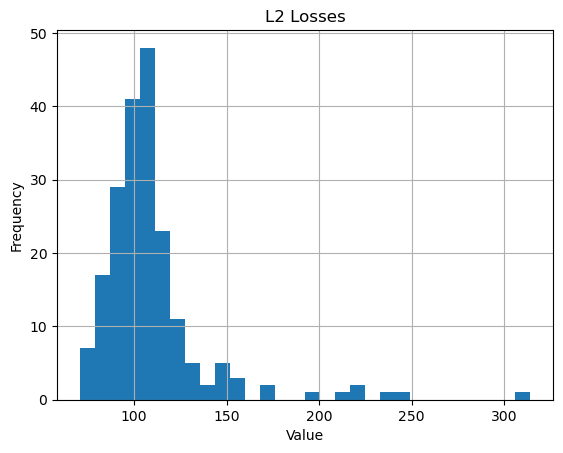

In [29]:
plt.hist(losses, bins=30)  # Adjust the number of bins as needed
plt.title('L2 Losses')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

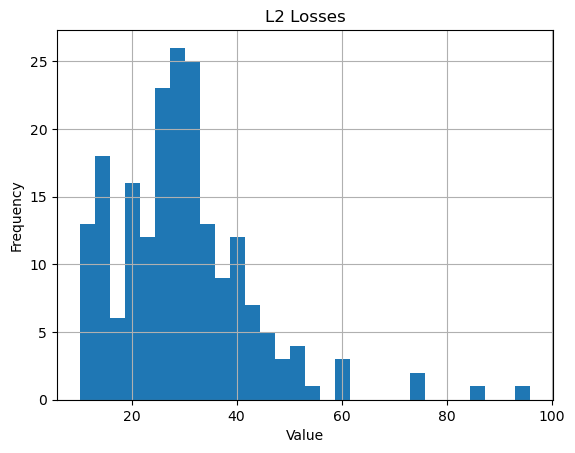

In [39]:
plt.hist(initial_losses, bins=30)  # Adjust the number of bins as needed
plt.title('L2 Losses')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

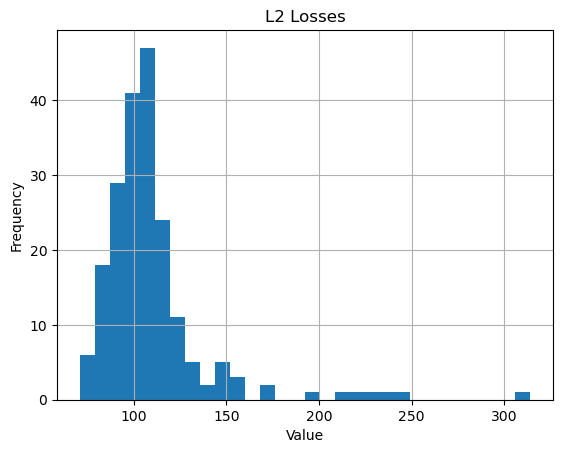

In [40]:
plt.hist(refined_losses, bins=30)  # Adjust the number of bins as needed
plt.title('L2 Losses')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

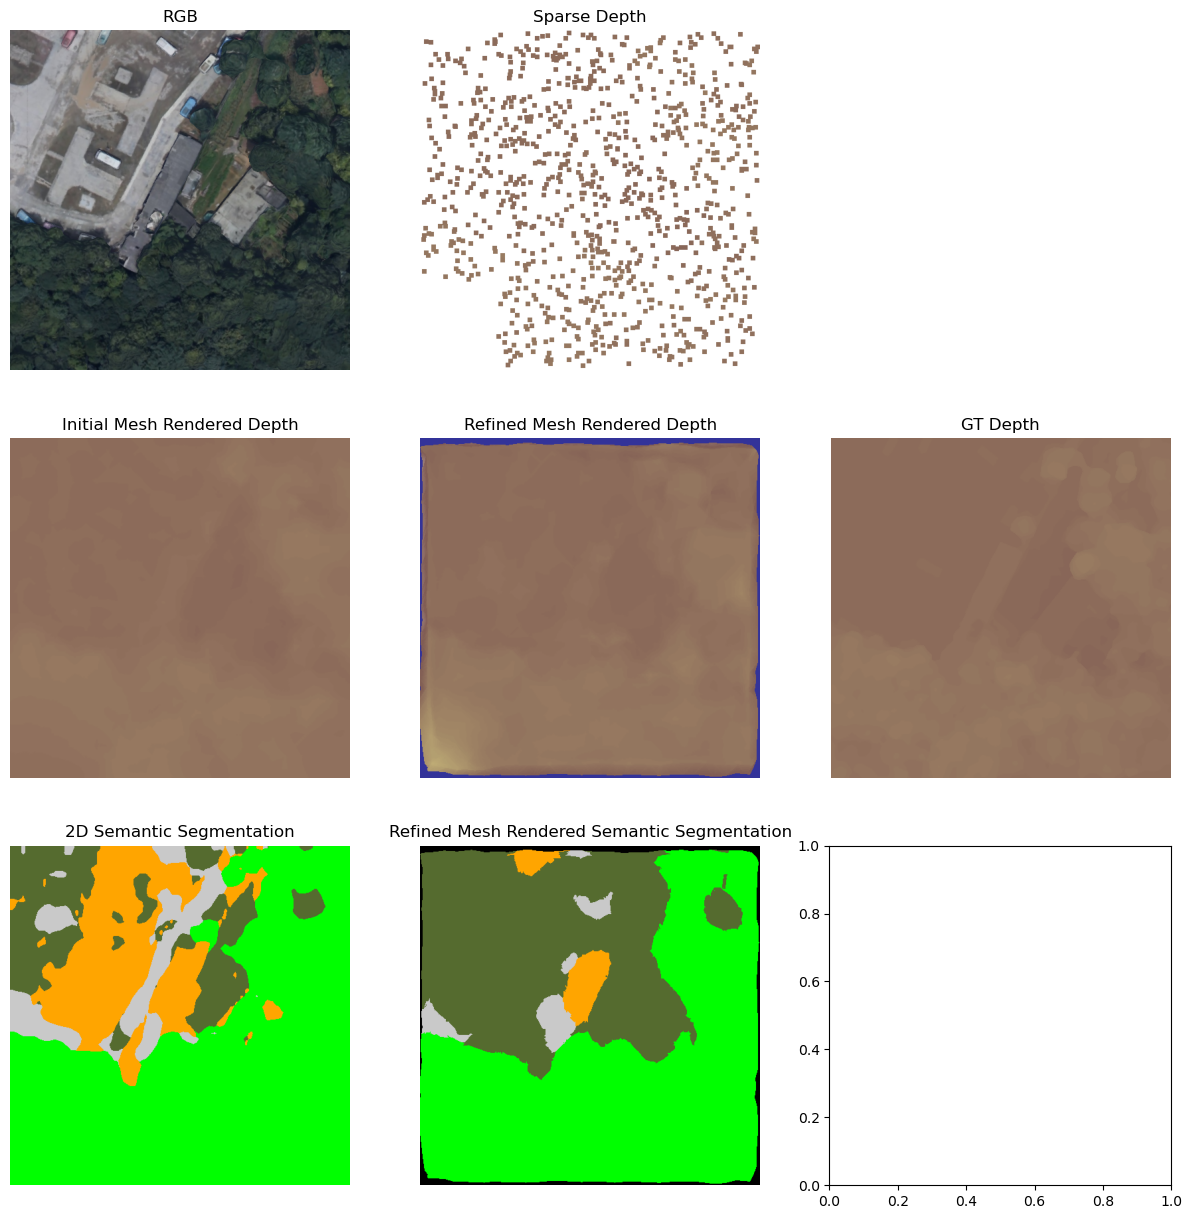

In [30]:
depth_scale = 64
depth_min = 0
depth_max = 700

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)
refine_mesh_semantic_vis = convert_class_to_rgb_sensat_simplified(refine_mesh_semantic)
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')

plt.show()

# Loading in data

/tmp/ipykernel_2299112/2202195682.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imread(rgb_file)
/tmp/ipykernel_2299112/2202195682.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sparsedepth = imread(sparse_depth_file)/depth_scale
/tmp/ipykernel_2299112/2202195682.py:34: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_depth = imread(gt_depth_file)/depth_scale


(-0.5, 511.5, 511.5, -0.5)

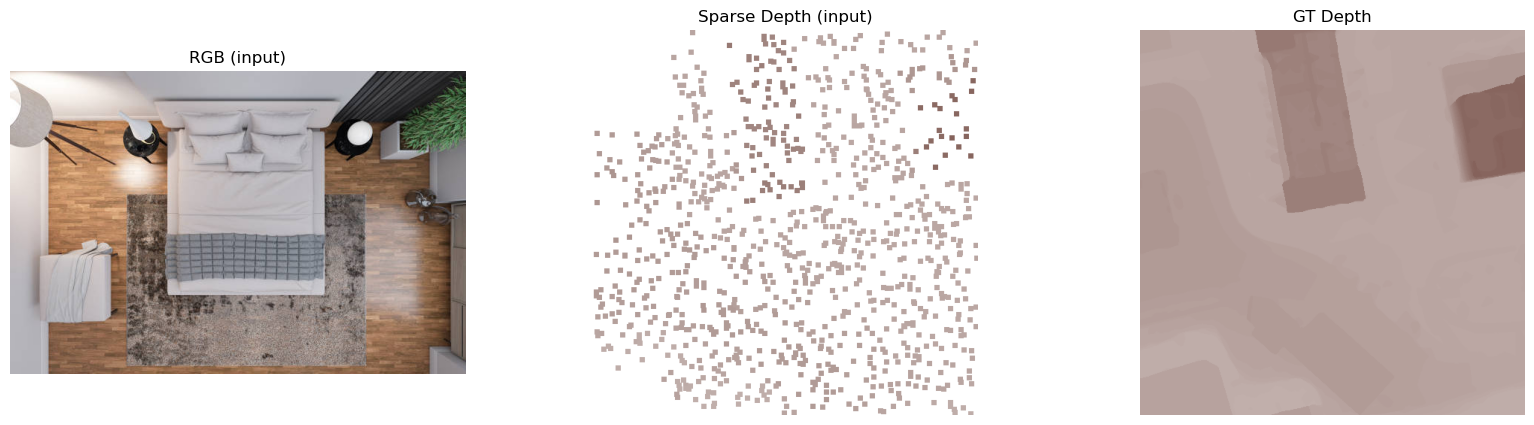

In [2]:
%matplotlib inline
from imageio import imread
import matplotlib.pyplot as plt
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map, pseudo_color_map_sparse

# rgb_file = "demo_data/RGB.png"
# sparse_depth_file = "demo_data/SparseDepth.png"
# gt_depth_file = "demo_data/GT_Depth.png"
# gt_sem_file = "demo_data/GT_Semantics.png"

depth_scale = 64
depth_min = 50
depth_max = 600

# rgb_file = "whu_test/009_67/Images/0000.png"
rgb_file = "misc/top_view_room.jpeg"

sparse_depth_file = "whu_test/009_67/Pcds_1000_gt/0000.png"
gt_depth_file = "whu_test/009_67/Depths/0000.png"
# gt_sem_file = "whu_test/002_50//GT_Semantics.png"

# Visualize the input data and the groundtruth
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,5))
rgb = imread(rgb_file) 
ax1.imshow(rgb)
ax1.set_title('RGB (input)')
ax1.axis('off')
sparsedepth = imread(sparse_depth_file)/depth_scale 
sparsedepth_vis = pseudo_color_map_sparse(sparsedepth,depth_min,depth_max)
ax2.imshow(sparsedepth_vis)
ax2.set_title('Sparse Depth (input)')
ax2.axis('off')
gt_depth = imread(gt_depth_file)/depth_scale
gt_depth_vis = pseudo_color_map(gt_depth,depth_min,depth_max)
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')

# 2D Image Segmentation

Using cache found in /users/nxu4/.cache/torch/hub/pytorch_vision_v0.8.0
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/nxu4/.conda/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


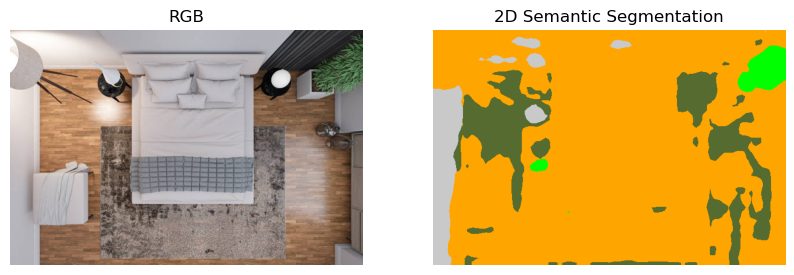

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from config import get_sensat_cfg

save_model_path = "checkpoints/deeplab/model_best_semantic.tar"
cfg_file = "Sensat_basic.yaml"

cfg = get_sensat_cfg()
cfg.merge_from_file(cfg_file)

# Load a trained deeplabv3 2D semantic segmentation model
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
model_2dseg = torch.hub.load('pytorch/vision:v0.8.0', 'deeplabv3_resnet50', pretrained=True)
model_2dseg.classifier[4] = nn.Conv2d(256, cfg.MODEL.DEEPLAB.NUM_CLASSES, kernel_size=1, stride=1)
model_2dseg.to(device)
checkpoint = torch.load(save_model_path)
model_2dseg.load_state_dict(checkpoint["model_state_dict"])
model_2dseg.eval()

# The input is an RGB image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(rgb)
input_img = input_tensor.unsqueeze(0).to(device)
pred_semantic_features = model_2dseg(input_img)["out"]
pred_semantic = pred_semantic_features.detach().max(dim=1)[1].cpu().numpy()[0,::]
pred_semantic_vis = convert_class_to_rgb_sensat_simplified(pred_semantic)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.imshow(rgb)
ax1.set_title('RGB')
ax1.axis('off')
ax2.imshow(pred_semantic_vis)
ax2.set_title('2D Semantic Segmentation')
ax2.axis('off')
plt.show()

# Mesh Initialization

[[522.9889  522.9819  522.97546 ... 527.88525 527.9127  527.83344]
 [522.96954 522.98004 522.97345 ... 527.8784  527.7992  527.7199 ]
 [522.95013 522.96063 522.9711  ... 527.7649  527.6856  527.6064 ]
 ...
 [525.0624  525.06647 524.9888  ... 530.49896 530.50555 530.5122 ]
 [525.04584 524.96814 524.8905  ... 530.5152  530.58044 530.5871 ]
 [524.9476  524.8698  524.7921  ... 530.5296  530.592   530.66187]]


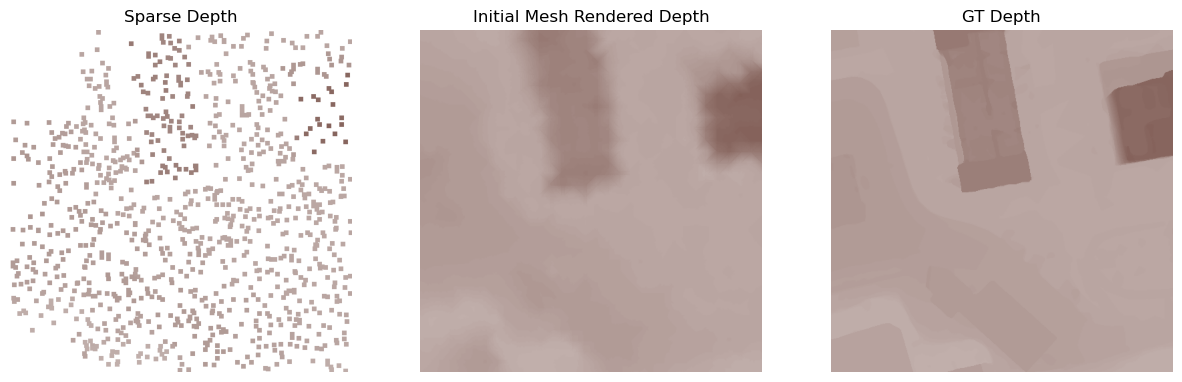

In [33]:
import plotly.graph_objects as go
import numpy as np 
from mesh_init.mesh_init_linear_solver import init_mesh_sparse
from mesh_init.mesh_renderer import mesh_render_depth
from pytorch3d.structures import Meshes
from vis.vis import texture_mesh_vertices

num_mesh_vertices = 1024
image_size = 512
focal_length = -2
depth_min = 50
depth_max = 600

# Initialize the mesh using only the sparse depth
init_mesh_vertices, init_mesh_faces = init_mesh_sparse(sparsedepth,num_mesh_vertices,w_laplacian=0.5)
init_mesh_vertices_tensor = torch.tensor(init_mesh_vertices,dtype=torch.float32,device=device)
init_mesh_faces_tensor = torch.tensor(init_mesh_faces,dtype=torch.int32,device=device)
init_mesh = Meshes(verts=[init_mesh_vertices_tensor], faces=[init_mesh_faces_tensor])

init_mesh_depth = mesh_render_depth(init_mesh,image_size=image_size,focal_length=focal_length)
print(init_mesh_depth)
init_mesh_depth_vis = pseudo_color_map(init_mesh_depth,depth_min,depth_max)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.imshow(sparsedepth_vis)
ax1.set_title('Sparse Depth')
ax1.axis('off')
ax2.imshow(init_mesh_depth_vis)
ax2.set_title('Initial Mesh Rendered Depth')
ax2.axis('off')
ax3.imshow(gt_depth_vis)
ax3.set_title('GT Depth')
ax3.axis('off')
plt.show()

init_mesh_height_color = texture_mesh_vertices(init_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])
# mp.plot(init_mesh_vertices@rotate_matrix, init_mesh_faces, init_mesh_height_color)

In [34]:
import os
from pytorch3d.structures import Meshes
from scipy import ndimage
from torchvision import transforms
from config import get_sensat_cfg
from model.models import VoxMeshHead

save_model_path = "checkpoints/Sem_Dice/model_best_depth.tar"
depth_scale = 100
device = torch.device("cuda:0")

# Load a trained 2D-3D model for mesh refinement
cfg = get_sensat_cfg()
cfg.merge_from_file(os.path.join(save_model_path,"..","Sensat_basic.yaml"))
model = VoxMeshHead(cfg)
checkpoint = torch.load(save_model_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

# Combine the 2D inputs, including the RGB, the initial mesh rendered depth and the sparse depth EDT.
rgb_tensor = transforms.ToTensor()(rgb).unsqueeze(0).to(device)
init_mesh_depth_tensor = transforms.ToTensor()(init_mesh_depth/depth_scale).unsqueeze(0).to(device)
sparsedepth_mask = (sparsedepth<=0)*1
depth_edt = ndimage.distance_transform_edt(sparsedepth_mask)
depth_edt_tensor = transforms.ToTensor()(depth_edt).unsqueeze(0).to(device)
input_img = torch.cat((rgb_tensor, init_mesh_depth_tensor, depth_edt_tensor), dim=1).to(torch.float)

# Normalized the mesh
init_mesh_scale = torch.mean(init_mesh_vertices_tensor[:,2])
init_mesh_vertices_norm_tensor = init_mesh_vertices_tensor / init_mesh_scale
init_mesh = Meshes(verts=[init_mesh_vertices_norm_tensor], faces=[init_mesh_faces_tensor])

# The model takes in the concatenated 2D inputs, the initial mesh and the 2D semantic segmentation
refine_mesh = model(input_img, init_mesh, pred_semantic_features)
refine_mesh = refine_mesh[1].scale_verts(init_mesh_scale.unsqueeze(0).to(device))

NameError: name 'gt_sem_vis' is not defined

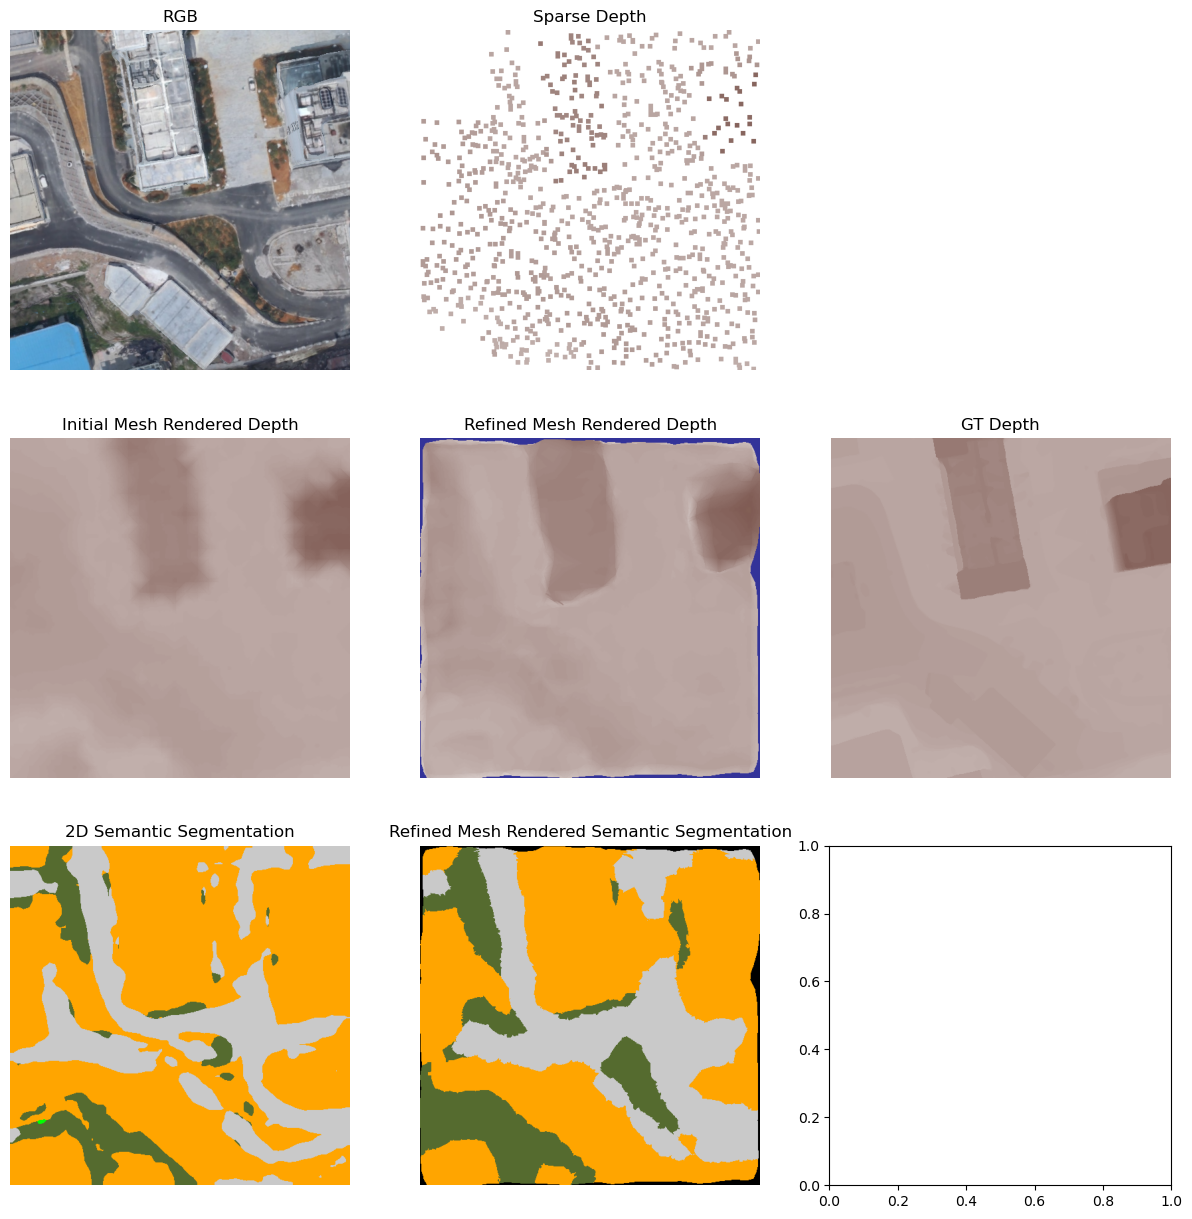

In [35]:
from mesh_init.mesh_renderer import render_mesh_texture
from utils.semantic_labels import convert_class_to_rgb_sensat_simplified 
from vis.vis import pseudo_color_map

device = torch.device("cuda:0")
depth_min = 50
depth_max = 600
image_size = 512
focal_length = -2

refine_mesh_semantic, refine_mesh_depth = render_mesh_texture(refine_mesh,image_size=image_size,focal_length=focal_length,device=device)
refine_mesh_semantic_vis = convert_class_to_rgb_sensat_simplified(refine_mesh_semantic)
refine_mesh_depth_vis = pseudo_color_map(refine_mesh_depth,depth_min,depth_max)

fig, ((ax11,ax12,ax13),(ax21,ax22,ax23),(ax31,ax32,ax33)) = plt.subplots(3,3,figsize=(15,15))

ax11.imshow(rgb)
ax11.set_title('RGB')
ax11.axis('off')
ax12.imshow(sparsedepth_vis)
ax12.set_title('Sparse Depth')
ax12.axis('off')
ax13.axis('off')

ax21.imshow(init_mesh_depth_vis)
ax21.set_title('Initial Mesh Rendered Depth')
ax21.axis('off')
ax22.imshow(refine_mesh_depth_vis)
ax22.set_title('Refined Mesh Rendered Depth')
ax22.axis('off')
ax23.imshow(gt_depth_vis)
ax23.set_title('GT Depth')
ax23.axis('off')

ax31.imshow(pred_semantic_vis)
ax31.set_title('2D Semantic Segmentation')
ax31.axis('off')
ax32.imshow(refine_mesh_semantic_vis)
ax32.set_title('Refined Mesh Rendered Semantic Segmentation')
ax32.axis('off')
ax33.imshow(gt_sem_vis)
ax33.set_title('GT Semantic')
ax33.axis('off')

plt.show()

refine_mesh_vertices, refine_mesh_faces = refine_mesh.get_mesh_verts_faces(0)
refine_mesh_vertices = refine_mesh_vertices.detach().cpu().numpy()
refine_mesh_faces = refine_mesh_faces.detach().cpu().numpy()
refine_mesh_height_color = texture_mesh_vertices(refine_mesh_vertices, depth_min, depth_max)
rotate_matrix = np.array([[1,0,0],[0,-np.sqrt(3)/2,1/2],[0,-1/2,-np.sqrt(3)/2]])

In [ ]:
import meshplot as mp
mp.plot(refine_mesh_vertices@rotate_matrix, refine_mesh_faces, refine_mesh_height_color)